# Assignment 10: Jörg, Ilmar, Tristan, Inken

## *Import modules*

In [1]:
import numpy as np
import xarray as xr
import scipy as sp
from scipy.signal import detrend
from scipy.stats import linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from seaborn import set_context
set_context('talk')

/home/marimp/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/marimp/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## *Function to load data*
The function loads the data and shifts it to fit the longitude range $-180$ to $180^\circ E$. Then the data is detrended and subsequently the seasonal cycle is removed.

In [2]:
def load_data():
    ds = xr.open_dataset('/course_materials/climdat/lecture/data/slp.mon.mean.nc')
    ds = ds.roll(lon = 71, roll_coords = True)
    lon = ds.lon.values
    ds.drop('lon')
    lon[lon > 180.] = - (360. - lon[lon > 180.])
    ds['lon'] = lon
    ds.assign_coords({'time': ds.time, 'lat': ds.lat, 'lon': lon})

    slp_det = detrend(ds.slp, axis = 0, type = 'linear')
    ds['slp_det'] = (('time','lat', 'lon'), slp_det)

    slp_des = ds.slp_det.groupby('time.month') - ds.slp_det.groupby('time.month').mean('time')
    ds['slp_des'] = (('time','lat', 'lon'), slp_des)
    return ds

## *Function for PCA*
The EOF analysis is applied using the scipy function *scipy.linalg.svd* also used in the lecture instead of the *eofs* package. The PC is standardised by its standard deviation, while the EOF is multiplied by the standard deviation of the PC (units are associated with the EOF pattern instead). The EOFs are also multiplied by the singular values. The PCs, EOFs and the explained variance, calculated from the singular values, are returned.

In [3]:
def pca(data, dim1, dim2):
    x = data.stack(tmp_space = dim2)
    x_dropped = x.dropna(dim = 'tmp_space')

    pc, s, eof = sp.linalg.svd(x_dropped, full_matrices = False)

    pc_std = pc.std(axis = 0)
    pc /= pc_std
    mode = np.arange(1, len(pc_std) + 1)
    pc = pc.T
    pc = xr.DataArray(
        pc,
        dims = ('mode', dim1),
        coords = {'mode': mode, dim1: x[dim1]}
    )

    exp_var = s ** 2. / (s ** 2.).sum()

    eof *= pc_std[:, np.newaxis]
    eof *= s[:, np.newaxis]

    eofs = x.copy()
    eofs[:, eofs[0].notnull().values] = eof
    eofs = eofs.unstack(dim = 'tmp_space').rename(**{dim1: 'mode'})
    eofs.coords['mode'] = mode
    
    return pc, eofs, exp_var

# **PCA / EOF: Exercise 1 (i), (ii) and (iii)**

In [4]:
ds = load_data()

FileNotFoundError: [Errno 2] No such file or directory: b'/course_materials/climdat/lecture/data/slp.mon.mean.nc'

The data is weighted by the cosine of latitude. The PCA is conducted for each case (i) to (iii), then the EOFs are divided by the weights again.

In [5]:
weight = np.sqrt(abs(np.cos(np.pi * ds.lat / 180.)))
ds *= weight

pc_des, eof_des, exp_var_des = pca(ds.slp_des, 'time', ('lat', 'lon'))
eof_des /= weight

pc_det, eof_det, exp_var_det = pca(ds.slp_det, 'time', ('lat', 'lon'))
eof_det /= weight

pc_NA, eof_NA, exp_var_NA = pca(
    ds.slp_des.sel(lat = slice(80., 20.), lon = slice(-90., 40.)), 'time', ('lat', 'lon')
)
eof_NA /= weight.sel(lat = slice(80., 20.))

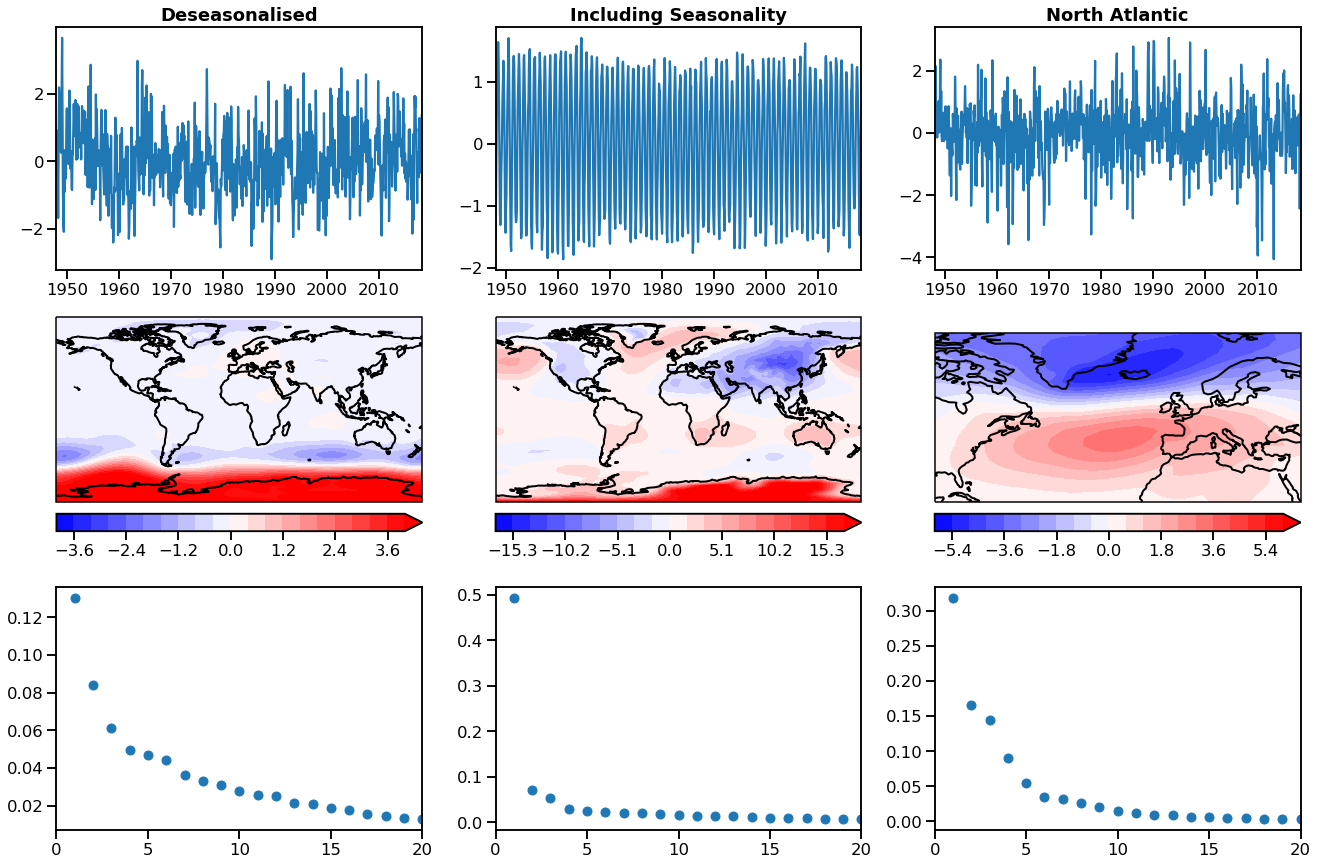

In [6]:
fig = plt.figure(figsize = (18, 12), clear = True)
fig.subplots_adjust(top = 0.98, bottom = 0.05,
                    right = 0.98, left = 0.02,
                    hspace = 0.15)

ax1_pc = fig.add_subplot(331)
ax1_pc.plot(pc_des.time, pc_des.sel(mode = 1))
ax1_pc.set_title('Deseasonalised', fontweight = 'bold')

ax1_eof = fig.add_subplot(334, projection = ccrs.PlateCarree())
cf1 = ax1_eof.contourf(eof_des.lon, eof_des.lat, eof_des.sel(mode = 1),
                       cmap = 'bwr', levels = np.linspace(-4., 4., 21),
                       extend = 'max', transform = ccrs.PlateCarree())

ax1_var = fig.add_subplot(337)
ax1_var.plot(np.arange(1., 21.), exp_var_des[:20], 'o')

ax2_pc = fig.add_subplot(332)
ax2_pc.plot(pc_det.time, pc_det.sel(mode = 1))
ax2_pc.set_title('Including Seasonality', fontweight = 'bold')

ax2_eof = fig.add_subplot(335, projection = ccrs.PlateCarree())
cf2 = ax2_eof.contourf(eof_det.lon, eof_det.lat, eof_det.sel(mode = 1),
                       cmap = 'bwr', levels = np.linspace(-17., 17., 21),
                       extend = 'max', transform = ccrs.PlateCarree())

ax2_var = fig.add_subplot(338)
ax2_var.plot(np.arange(1., 21.), exp_var_det[:20], 'o')

ax3_pc = fig.add_subplot(333)
ax3_pc.plot(pc_NA.time, -pc_NA.sel(mode = 1))
ax3_pc.set_title('North Atlantic', fontweight = 'bold')

ax3_eof = fig.add_subplot(336, projection = ccrs.PlateCarree())
cf3 = ax3_eof.contourf(eof_NA.lon, eof_NA.lat, -eof_NA.sel(mode = 1),
                       cmap = 'bwr', levels = np.linspace(-6., 6., 21),
                       extend = 'max', transform = ccrs.PlateCarree())

ax3_var = fig.add_subplot(339)
ax3_var.plot(np.arange(1., 21.), exp_var_NA[:20], 'o')

for ax in [ax1_pc, ax2_pc, ax3_pc]:
    ax.set_xlim([ds.time.min(), ds.time.max()])
for ax, cf in zip([ax1_eof, ax2_eof, ax3_eof], [cf1, cf2, cf3]):
    ax.coastlines(color = 'k', linewidth = 2)
    plt.colorbar(cf, ax = ax, pad = 0.05,
                 orientation = 'horizontal')
for ax in [ax1_var, ax2_var, ax3_var]:
    ax.set_xlim([0., 20.])

### **(i) Fully corrected data**
The first EOF of the global SLP seems to be dominated by the Southern Annular Mode, which is defined by the pressure difference between the Southern Hemisphere high-latitudes and mid-latitudes. This pattern would correspond to the negative phase of the SAM.

### **(ii) Including seasonality**
If the seasonality is kept in, the first EOF is dominated by the seasonality (mainly seasonally varying pressure over Asia and the Antarctic Continent), which can also be seen in the first PC that shows a pronounced semiannual timescale.

In the Eigenvalue Spectrum the first mode now explains about $50\%$ of the total variance which is much more than the first mode in the seasonally corrected experiment showed. This emphasizes the role of the seasonal cycle in overall variability of our climate.

### **(iii) North Atlantic**
This pattern fits very well to the NAO pattern, with high pressure over the Azores and low pressure over Iceland. Here the sign of both the EOF and the PC is swapped such that the pattern fits to the better known positive NAO pattern.

# **Regression: Exercise 1 (iv)**
## *Function to calculate linear regression*
The function uses the *scipy.stats.linregress* method to calculate the slope of the linear regression.

In [7]:
def lin_regress(x, y):
    reg_slope, _, _, _, _ = linregress(x, y)
    return reg_slope

The data is loaded and the seasonal cycle is removed. The data is further detrended and the mode 1 PC for the North Atlantic is extracted from the previously calculated PCs.

In [8]:
air = xr.open_dataset(
    '/course_materials/climdat/lecture/data/air.mon.mean.nc',
    chunks = {'lat': 15, 'lon': 15}
).sel(time = slice('1948-01-01', '2018-05-01'))
air = air.groupby('time.month') - air.groupby('time.month').mean('time')
air = air.chunk({'time': -1})
air_det = detrend(air.air, axis = 0, type = 'linear')
air['air'] = (('time', 'lat', 'lon'), air_det)
NAO = pc_NA.sel(mode = 1)

/opt/tljh/user/envs/climDat/lib/python3.8/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 71 times more chunks
  return self.array[key]


For each grid point the air tempereture is regressed onto the NAO Index.

In [9]:
slope = xr.apply_ufunc(lin_regress,
                       -NAO, air.air,
                       vectorize = True,
                       dask = 'parallelized',
                       input_core_dims = [['time'], ['time']],
                       output_dtypes = ['d']).compute()

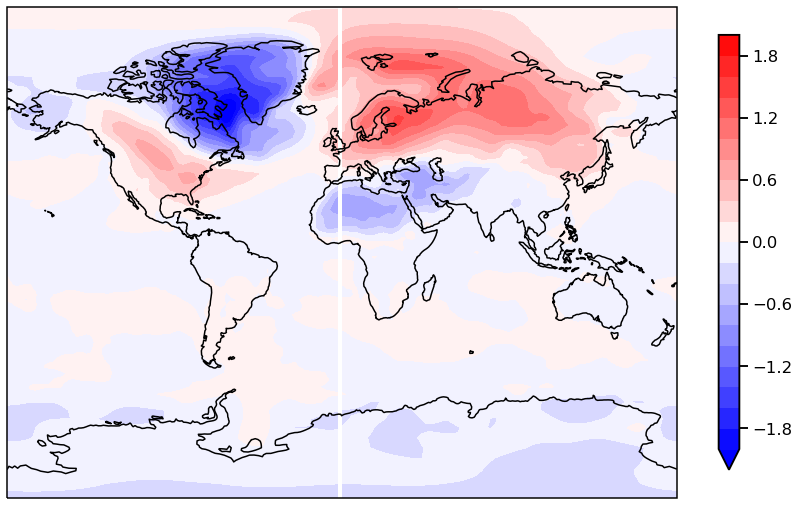

In [10]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111, projection = ccrs.Miller())
plt.contourf(slope.lon, slope.lat, slope, cmap = 'bwr',
             levels = np.linspace(-2., 2., 21), extend = 'min',
             transform = ccrs.PlateCarree())
plt.colorbar(shrink = 0.8)
ax.coastlines()

A positive phase of the NAO is related to colder temperatures over Greenland and the Labrador Sea, which has impacts on Deep Water Formation. In Eurasia a positive NAO is in contrast related to warmer temperatures.